In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '75-efficientnetb6'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'

import os
# os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [5]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers

SEED = 42
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## TPU configuration

In [6]:
#@title
strategy, tpu = set_up_strategy()
REPLICAS = strategy.num_replicas_in_sync
print("REPLICAS: ", REPLICAS)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.6.136.202:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.6.136.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.6.136.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# Model parameters

In [7]:
config = {
  "HEIGHT": 384,
  "WIDTH": 384,
  "CHANNELS": 3,
  "BATCH_SIZE": 256,
  "EPOCHS": 12,
  "LEARNING_RATE": 0.00000125 * REPLICAS * 256,
  "ES_PATIENCE": 5,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 1,
  "TTA_STEPS": 10,
  "BASE_MODEL": 'EfficientNetB6',
  "BASE_MODEL_WEIGHTS": 'imagenet',
  "DATASET_PATH": 'melanoma-384x384'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB6',
 'BASE_MODEL_WEIGHTS': 'imagenet',
 'BATCH_SIZE': 256,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-384x384',
 'EPOCHS': 12,
 'ES_PATIENCE': 5,
 'HEIGHT': 384,
 'LEARNING_RATE': 0.00256,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 1,
 'TTA_STEPS': 10,
 'WIDTH': 384}

# Load data

In [8]:
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-3c0c447892078c6cb0cb069958214c9fedc65fe9efc33682fef72a3e'
TRAINING_FILENAMES = np.sort(tf.io.gfile.glob(GCS_PATH + '/train*.tfrec'))
TEST_FILENAMES = np.sort(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec'))

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [47]:
#@title
def data_augment(image, label):
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')

    image['input_image'] = data_augment_shift(image['input_image'])
    image['input_image'] = data_augment_shear(image['input_image'])
    image['input_image'] = data_augment_rotation(image['input_image'])

    if p_crop >= .6: # Crops
      image['input_image'] = data_augment_crop(image['input_image'])

    image['input_image'] = data_augment_spatial(image['input_image'])
    image['input_image'] = data_augment_saturation(image['input_image'])
    image['input_image'] = data_augment_contrast(image['input_image'])
    image['input_image'] = data_augment_brightness(image['input_image'])

    image['input_image'] = tf.reshape(image['input_image'], [config['HEIGHT'], config['WIDTH'], config['CHANNELS']])
    
    return image, label

def data_augment_rotation(image, max_angle=45.):
    image = transform_rotation(image, config['HEIGHT'], max_angle)
    return image

def data_augment_shift(image, h_shift=50., w_shift=50.):
    image = transform_shift(image, config['HEIGHT'], h_shift, w_shift)
    return image

def data_augment_shear(image, shear=25.):
    image = transform_shear(image, config['HEIGHT'], shear)
    return image

def data_augment_hue(image, max_delta=.02):
    image = tf.image.random_hue(image, max_delta)
    return image

def data_augment_saturation(image, lower=.7, upper=1.3):
    image = tf.image.random_saturation(image, lower, upper)
    return image

def data_augment_contrast(image, lower=.8, upper=1.2):
    image = tf.image.random_contrast(image, lower, upper)
    return image

def data_augment_brightness(image, max_delta=.1):
    image = tf.image.random_brightness(image, max_delta)
    return image

def data_augment_spatial(image):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)    
    if p_spatial > .75:
        image = tf.image.transpose(image)

    return image

def data_augment_rotate(image):
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_rotate > .66:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .33:
        image = tf.image.rot90(image, k=2) # rotate 180º
    else:
        image = tf.image.rot90(image, k=1) # rotate 90º

    return image

def data_augment_crop(image):
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_crop > .8:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
    elif p_crop > .6:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
    elif p_crop > .4:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
    elif p_crop > .2:
        image = tf.image.central_crop(image, central_fraction=.8)
    else:
        image = tf.image.central_crop(image, central_fraction=.7)

    image = tf.image.resize(image, size=[config['HEIGHT'], config['WIDTH']])

    return image

def data_augment_cutout(image, min_mask_size=(int(config['HEIGHT'] * .05), int(config['HEIGHT'] * .05)), 
                        max_mask_size=(int(config['HEIGHT'] * .25), int(config['HEIGHT'] * .25))):
    p_cutout = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_cutout > .9: # 3 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=3)
    elif p_cutout > .75: # 2 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=2)
    else: # 1 cut out
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

## Auxiliary functions

In [48]:
#@title
# Datasets utility functions
def read_tfrecord(example, labeled=False, return_names=False, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    if labeled:
        example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
        label = tf.cast(example['target'], tf.float32)
    else:
        example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    if return_names or labeled:
        image_name = example['image_name']

    image = decode_image(example['image'], height, width, channels)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    if not labeled:
        return {'input_image': image, 'input_meta': data}, image_name

    if not return_names:
        return {'input_image': image, 'input_meta': data}, label

    return {'input_image': image, 'input_meta': data}, label, image_name


def load_dataset(filenames, labeled=False, return_names=False, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size)
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(lambda example: read_tfrecord(example, labeled, return_names), num_parallel_calls=buffer_size)   
    return dataset

def get_dataset(filenames, labeled=True, return_names=False, ordered=False, repeated=False, augment=False, 
                batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, labeled, return_names, ordered, buffer_size)
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=buffer_size)
    if repeated:
        dataset = dataset.repeat()
    if not ordered:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

## Learning rate scheduler

Learning rate schedule: 5e-06 to 0.00256 to 0.000671


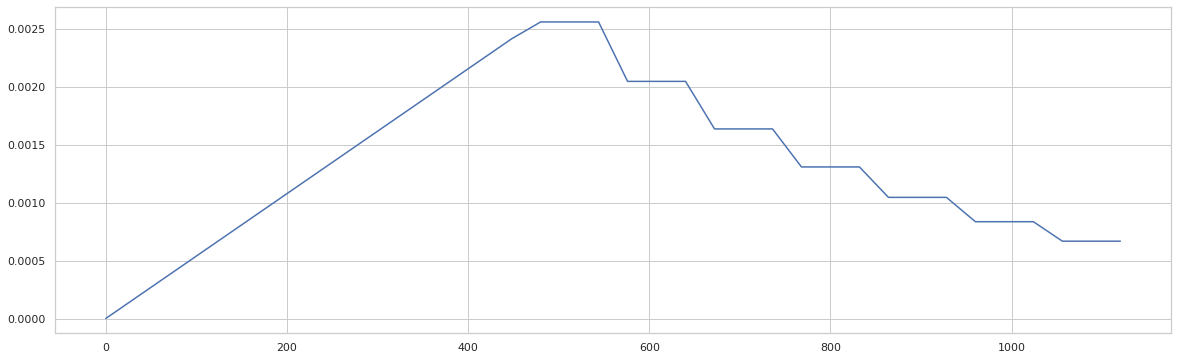

In [49]:
#@title
lr_min = 1e-6
lr_start = 5e-6
lr_max = config['LEARNING_RATE']
steps_per_epoch = 24519 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch
warmup_steps = steps_per_epoch * 5
hold_max_steps = 0
step_decay = .8
step_size = steps_per_epoch * 1

rng = [i for i in range(0, total_steps, 32)]
y = [step_schedule_with_warmup(tf.cast(x, tf.float32), step_size=step_size, 
                               warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                               lr_start=lr_start, lr_max=lr_max, step_decay=step_decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [50]:
#@title
# Initial bias
pos = len(k_fold[k_fold['target'] == 1])
neg = len(k_fold[k_fold['target'] == 0])
initial_bias = np.log([pos/neg])
print('Bias')
print(pos)
print(neg)
print(initial_bias)

# class weights
total = len(k_fold)
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Class weight')
print(class_weight)

Bias
581
32111
[-4.01220317]
Class weight
{0: 0.509046744106381, 1: 28.1342512908778}


In [51]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB6(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    
    output = L.Dense(1, activation='sigmoid', name='output', 
                     bias_initializer=tf.keras.initializers.Constant(initial_bias))(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [52]:
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
NUM_TRAIN_IMAGES = count_data_items(TRAINING_FILENAMES)
# Evaluation
eval_dataset = get_dataset(TRAINING_FILENAMES, labeled=False, return_names=True, ordered=True, repeated=False, augment=False, 
                           batch_size=1024, buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TRAIN_IMAGES))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, image_name: data)

# Test
test_preds = np.zeros((NUM_TEST_IMAGES, 1)); test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))
test_dataset = get_dataset(TEST_FILENAMES, labeled=False, return_names=True, ordered=True, repeated=False, augment=True, 
                           batch_size=1024, buffer_size=AUTO)
image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
test_image_data = test_dataset.map(lambda data, image_name: data)

# Resample dataframe
k_fold = k_fold[k_fold['image_name'].isin(image_names)]
k_fold_best = k_fold.copy()

kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)
history_list = []

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: step_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                   step_size=step_size, warmup_steps=warmup_steps, 
                                                   hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                   lr_max=lr_max, step_decay=step_decay)
            
            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])
            
        history = model.fit(get_dataset(train_filenames, labeled=True, return_names=False, ordered=False, repeated=True, 
                                        augment=True, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_dataset(valid_filenames, labeled=True, return_names=False, ordered=False, 
                                                        repeated=False, augment=False, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch,
                            callbacks=[checkpoint],
                            # class_weight=class_weight, 
                            verbose=2).history

        history_list.append(history)

        # Save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        # Get validation IDs
        valid_dataset = get_dataset(valid_filenames, labeled=False, return_names=True, ordered=True, repeated=False, 
                                    augment=False, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print(f'Last model evaluation...')
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print(f'Last model inference (TTA {config["TTA_STEPS"]} steps)...')
        for step in range(config['TTA_STEPS']):
            test_preds_last += model.predict(test_image_data)

        ##### Best model #####
        print(f'Best model evaluation...')
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print(f'Best model inference (TTA {config["TTA_STEPS"]} steps)...')
        for step in range(config['TTA_STEPS']):
            test_preds += model.predict(test_image_data)


# normalize preds
test_preds /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))

test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.6.136.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.6.136.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
102/102 - 159s - auc: 0.6786 - loss: 0.1742 - val_auc: 0.6183 - val_loss: 0.1863
Epoch 2/12
102/102 - 130s - auc: 0.8026 - loss: 0.1697 - val_auc: 0.7492 - val_loss: 0.1729
Epoch 3/12
102/102 - 126s - auc: 0.8063 - loss: 0.1698 - val_auc: 0.7985 - val_loss: 0.7081
Epoch 4/12
102/102 - 126s - auc: 0.8114 - loss: 0.1689 - val_auc: 0.7737 - val_loss: 0.2021
Epoch 5/12
102/102 - 131s - auc: 0.8012 - loss: 0.1684 - val_auc: 0.8022 - val_loss: 0.1700
Epoch 6/12
102/102 - 124s - auc: 0.8079 - loss: 0.1697 - val_auc: 0.7582 - val_loss: 0.1790
Epoch 7/12
102/102 - 124s - auc: 0.8353 - loss: 0.1681 - val_auc: 0.8176 - val_loss: 0.1712
Epoch 8/12
102/102 - 131s - auc: 0.8607 - loss: 0.1651 - val_auc: 0.8467 - val_loss: 0.1692
Epoch 9/12
102/102 - 132s - auc: 0.8768 - loss: 0.1640 - val_auc: 0.8394 - val_loss: 0.1668
Epoch 10/12
102/102 - 126s - auc: 0.8705 - loss: 0.1643 - val_auc: 0.8457 - val_loss: 0.1684
Epoch 11/12
102/102 - 131s - auc: 0.8806 - loss: 0.1630 - val_auc: 0.8830 - val

## Model loss graph

Fold: 1


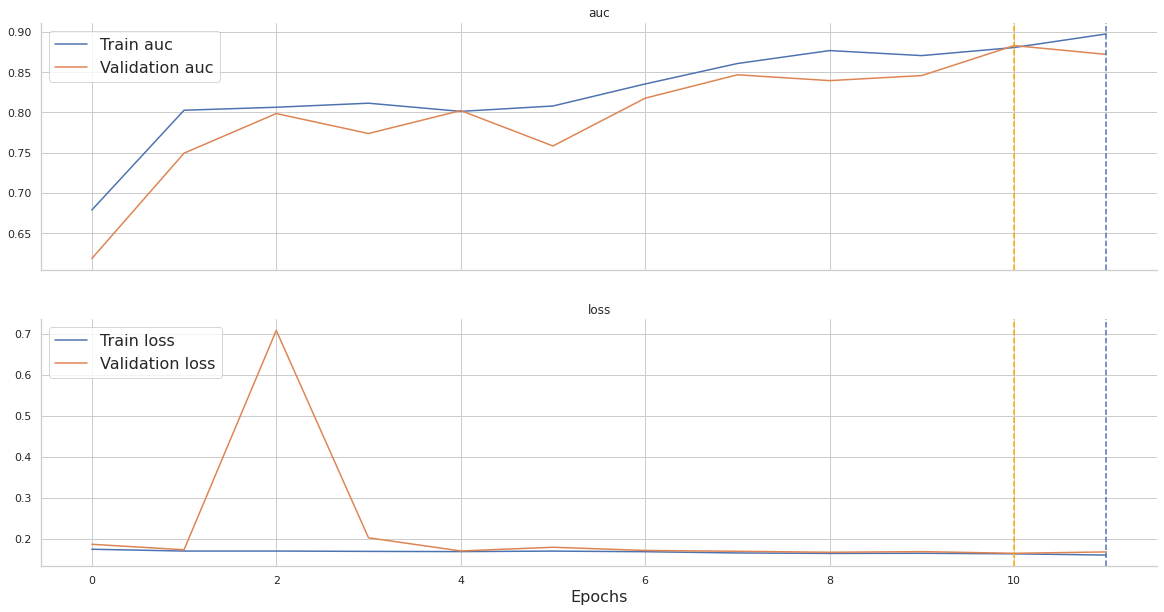

In [53]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

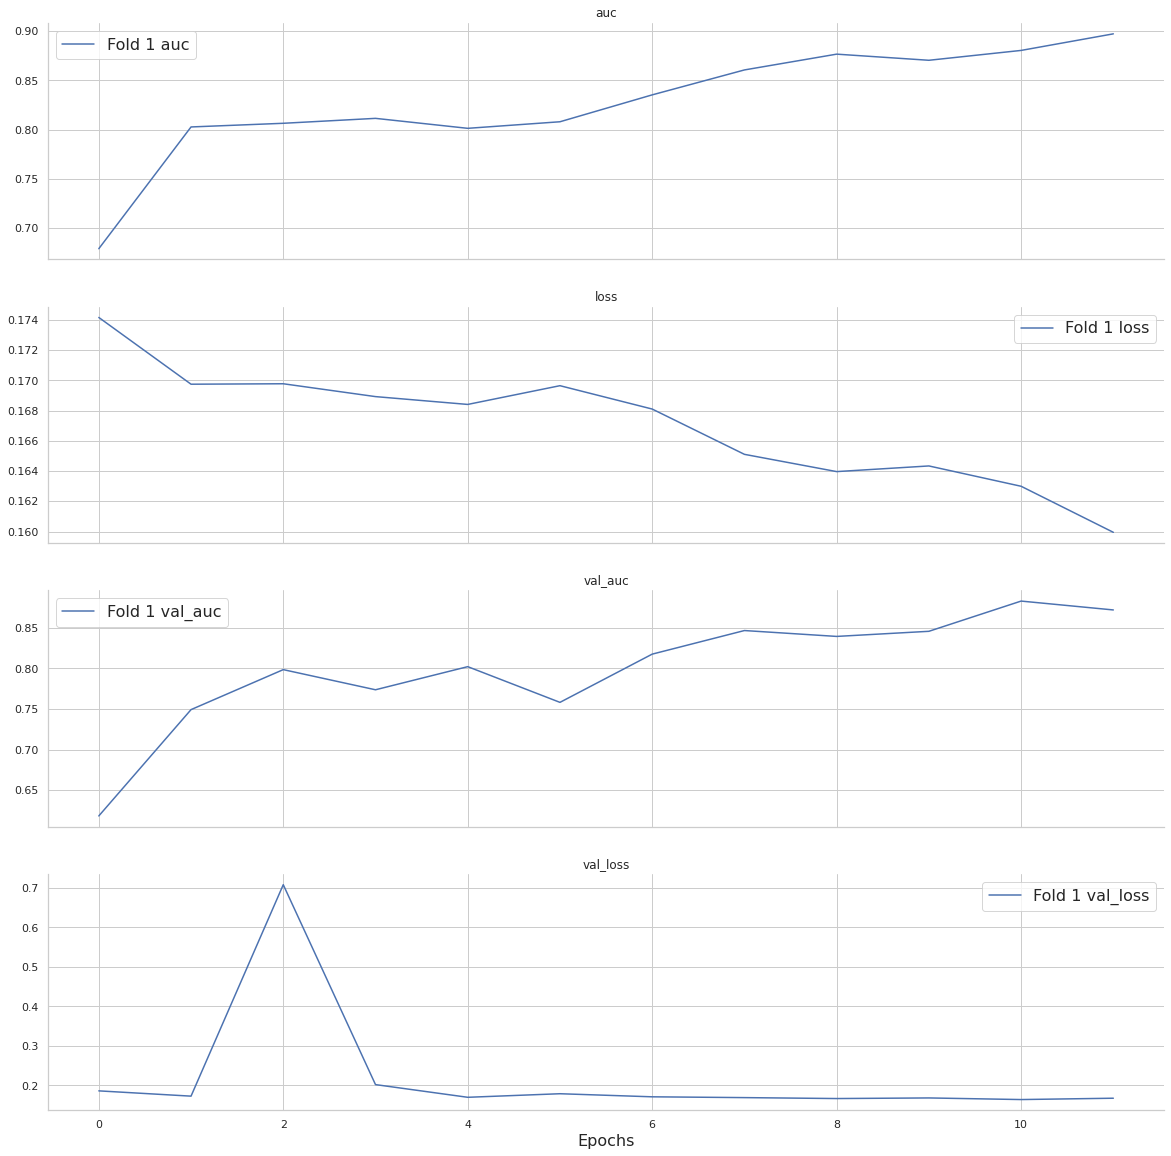

In [54]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation (best)

In [56]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1
Metric,,,,,
ROC AUC,0.920580,0.888131,0.032449,0.920580,0.888131
Accuracy,0.982757,0.982099,0.000658,0.982757,0.982099
Precision,0.888889,0.333333,0.555556,0.888889,0.333333
Recall,0.034409,0.008621,0.025788,0.034409,0.008621
F1-score,0.066253,0.016807,0.049446,0.066253,0.016807
Support,465.000000,116.000000,349.000000,465.000000,116.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1
Subset/ROC AUC,,,,,
Overall,0.920580,0.888131,0.032449,0.920580,0.888131
male,0.921871,0.900050,0.021821,0.921871,0.900050
female,0.914105,0.873267,0.040837,0.914105,0.873267
head/neck,0.915879,0.846099,0.069780,0.915879,0.846099
upper extremity,0.930668,0.884678,0.045990,0.930668,0.884678
lower extremity,0.874556,0.845763,0.028792,0.874556,0.845763
torso,0.932570,0.928269,0.004301,0.932570,0.928269
0 <= age < 26,0.914354,0.671672,0.242681,0.914354,0.671672
26 <= age < 40,0.882912,0.796712,0.086200,0.882912,0.796712


# Model evaluation (last)

In [57]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1
Metric,,,,,
ROC AUC,0.920039,0.881964,0.038075,0.920039,0.881964
Accuracy,0.982910,0.981946,0.000964,0.982910,0.981946
Precision,0.821429,0.000000,0.821429,0.821429,0.000000
Recall,0.049462,0.000000,0.049462,0.049462,0.000000
F1-score,0.093306,0.000000,0.093306,0.093306,0.000000
Support,465.000000,116.000000,349.000000,465.000000,116.000000


# Confusion matrix

Fold: 1


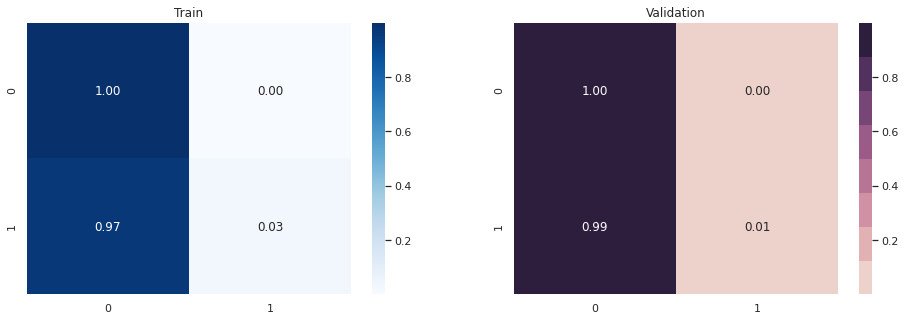

In [58]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

Label/prediction distribution
Train positive labels: 581
Train positive predictions: 0
Train positive correct predictions: 0
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_best,pred_fold_1,pred_fold_0
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.004875,0.005641,0.024377,0.035849
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.004908,0.004991,0.024542,0.033297
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.004733,0.005058,0.023667,0.027331
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.008433,0.006517,0.042165,0.029629
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.004598,0.004598,0.022992,0.029604
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.004738,0.004913,0.023689,0.026992
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.004639,0.005376,0.023194,0.026398
7,ISIC_0075663,female,35.0,torso,unknown,0,0.005687,0.007383,0.028433,0.032609
8,ISIC_0075914,male,30.0,torso,unknown,0,0.004787,0.004933,0.023934,0.028856
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.004929,0.004896,0.024644,0.039570


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_best,pred_fold_1,pred_fold_0
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.004837,0.004869,0.024186,0.026989
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.014866,0.068256,0.074328,0.037290
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.005827,0.007521,0.029134,0.028346
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.006837,0.008865,0.034183,0.030693
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.013171,0.020522,0.065856,0.028344
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.030535,0.041522,0.152675,0.033805
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.005169,0.005922,0.025847,0.024814
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.021493,0.011923,0.107466,0.025649
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.034755,0.014518,0.173775,0.030291
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.006579,0.012054,0.032896,0.052249


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_best,pred_fold_1,pred_fold_0


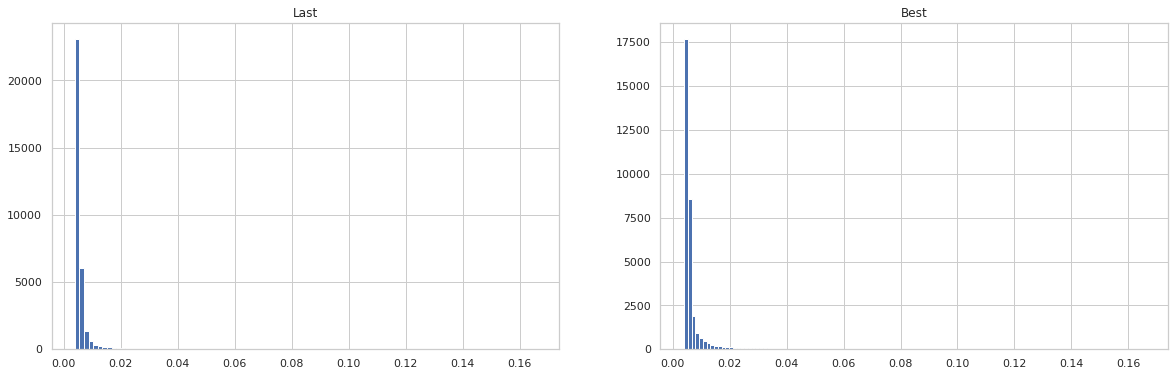

In [59]:
#@title
k_fold['pred'] = 0
k_fold_best['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']
    k_fold_best['pred'] += k_fold_best[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

k_fold['pred_best'] = k_fold_best['pred']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred', 'pred_best'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred', 'pred_best'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred', 'pred_best'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(20, 6))
ax1.hist(k_fold['pred'], bins=100)
ax2.hist(k_fold['pred_best'], bins=100)
ax1.set_title('Last')
ax2.set_title('Best')
plt.show()

# Visualize test predictions

Test predictions 7|10975
Test predictions (last) 15|10967
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
0,ISIC_0052060,male,70.0,NaN,0.025661,0.023055
1,ISIC_0052349,male,40.0,lower extremity,0.024589,0.022790
2,ISIC_0058510,female,55.0,torso,0.026491,0.025778
3,ISIC_0073313,female,50.0,torso,0.024568,0.023809
4,ISIC_0073502,female,45.0,lower extremity,0.033544,0.032731
5,ISIC_0074618,male,50.0,lower extremity,0.043244,0.045041
6,ISIC_0076801,male,45.0,upper extremity,0.029138,0.026490
7,ISIC_0077586,male,50.0,lower extremity,0.064202,0.039864
8,ISIC_0082004,female,45.0,torso,0.039075,0.033406
9,ISIC_0082785,male,65.0,lower extremity,0.072918,0.030432


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
1408,ISIC_1364884,female,35.0,upper extremity,0.596564,0.605970
3045,ISIC_2839742,male,70.0,upper extremity,0.505146,0.478741
4588,ISIC_4235197,male,60.0,torso,0.564862,0.540555
7980,ISIC_7233451,female,45.0,torso,0.543163,0.708011
8078,ISIC_7318419,female,35.0,head/neck,0.500162,0.527575
8188,ISIC_7442694,female,45.0,upper extremity,0.506128,0.593029
8863,ISIC_8059373,male,55.0,torso,0.523959,0.655553


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
1408,ISIC_1364884,female,35.0,upper extremity,0.596564,0.605970
2771,ISIC_2582691,male,65.0,NaN,0.437277,0.553318
3120,ISIC_2914164,male,40.0,head/neck,0.342590,0.534081
4588,ISIC_4235197,male,60.0,torso,0.564862,0.540555
5658,ISIC_5187012,male,35.0,torso,0.470290,0.502582
7443,ISIC_6744070,male,50.0,head/neck,0.244790,0.595044
7582,ISIC_6883060,male,50.0,torso,0.396588,0.531960
7645,ISIC_6935489,female,65.0,torso,0.432855,0.534055
7980,ISIC_7233451,female,45.0,torso,0.543163,0.708011
8032,ISIC_7276897,male,70.0,head/neck,0.252549,0.501965


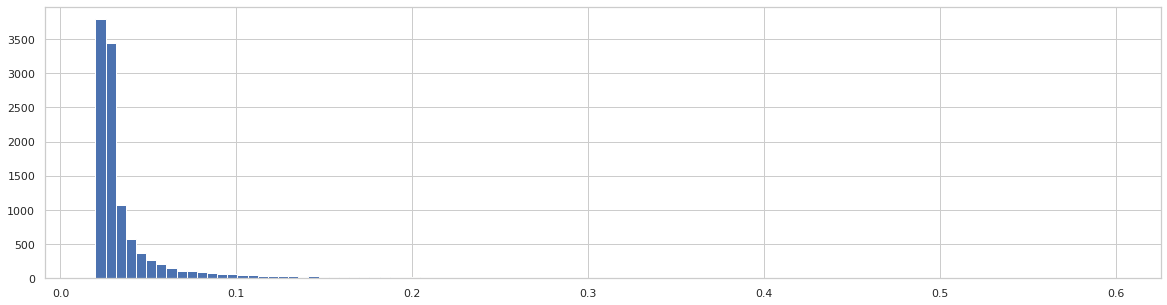

In [60]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last']
             + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last']
             + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last']
             + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

fig = plt.subplots(figsize=(20, 5))
plt.hist(test['target'], bins=100)
plt.show()

# Test set predictions

In [61]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend
0,ISIC_0052060,0.025661,0.023055,0.024358
1,ISIC_0052349,0.024589,0.022790,0.023689
2,ISIC_0058510,0.026491,0.025778,0.026135
3,ISIC_0073313,0.024568,0.023809,0.024188
4,ISIC_0073502,0.033544,0.032731,0.033138
5,ISIC_0074618,0.043244,0.045041,0.044142
6,ISIC_0076801,0.029138,0.026490,0.027814
7,ISIC_0077586,0.064202,0.039864,0.052033
8,ISIC_0082004,0.039075,0.033406,0.036240
9,ISIC_0082785,0.072918,0.030432,0.051675


,target,target_last,target_blend
count,10982.000000,10982.000000,10982.000000
mean,0.041720,0.034762,0.038241
std,0.044855,0.038547,0.039988
min,0.019867,0.018720,0.019890
25%,0.024932,0.023676,0.024345
50%,0.027488,0.025573,0.026668
75%,0.036654,0.030681,0.033923
max,0.596564,0.708011,0.625587
